In [24]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [25]:
def load_audio_files(data_dir, folders):
    features_list = []
    labels = []
    
    for label in folders:
        folder_path = os.path.join(data_dir, label)
        for file_path in glob.glob(os.path.join(folder_path, '*.wav')):
            sr, data = wavfile.read(file_path)
            
            # Handle stereo audio
            if len(data.shape) > 1:
                data = data[:, 0]
                
            features = extract_features(data, sr)
            features_list.append(features)
            labels.append(label)
    
    return features_list, labels

In [26]:
def extract_features(data, sr):
    n = len(data)
    fft_result = rfft(data)
    magnitudes = np.abs(fft_result)
    freqs = rfftfreq(n, d=1/sr)
    
    # Basic statistics
    mean = np.mean(magnitudes)
    median = np.median(magnitudes)
    std = np.std(magnitudes)
    var = np.var(magnitudes)
    max_mag = np.max(magnitudes)
    min_mag = np.min(magnitudes)
    percentile_25 = np.percentile(magnitudes, 25)
    percentile_75 = np.percentile(magnitudes, 75)
    
    # Spectral centroid
    if np.sum(magnitudes) == 0:
        spectral_centroid = 0
    else:
        spectral_centroid = np.sum(freqs * magnitudes) / np.sum(magnitudes)
    
    deviations = freqs - spectral_centroid
    
    # Spectral bandwidth
    if np.sum(magnitudes) == 0:
        spectral_bandwidth = 0
    else:
        spectral_bandwidth = np.sqrt(np.sum((deviations ** 2) * magnitudes) / np.sum(magnitudes))
    
    # Spectral flatness
    epsilon = 1e-10
    geometric_mean = np.exp(np.mean(np.log(magnitudes + epsilon)))
    arithmetic_mean = np.mean(magnitudes + epsilon)
    spectral_flatness = geometric_mean / arithmetic_mean
    
    # Spectral rolloff (85%)
    total_energy = np.sum(magnitudes ** 2)
    spectral_rolloff = 0
    if total_energy > 0:
        cumulative_energy = np.cumsum(magnitudes ** 2)
        threshold = 0.85 * total_energy
        rolloff_index = np.where(cumulative_energy >= threshold)[0]
        if len(rolloff_index) > 0:
            spectral_rolloff = freqs[rolloff_index[0]]
    
    # Peak frequency
    peak_index = np.argmax(magnitudes)
    peak_frequency = freqs[peak_index] if len(magnitudes) > 0 else 0
    
    # RMS
    rms = np.sqrt(np.mean(magnitudes ** 2))
    
    # Spectral skewness
    spectral_skewness = 0
    if spectral_bandwidth != 0 and np.sum(magnitudes) != 0:
        spectral_skewness = np.sum((deviations ** 3) * magnitudes) / (np.sum(magnitudes) * (spectral_bandwidth ** 3))
    
    # Spectral kurtosis
    spectral_kurtosis = 0
    if spectral_bandwidth != 0 and np.sum(magnitudes) != 0:
        spectral_kurtosis = np.sum((deviations ** 4) * magnitudes) / (np.sum(magnitudes) * (spectral_bandwidth ** 4))
    
    return [
        mean, median, std, var, max_mag, min_mag,
        percentile_25, percentile_75,
        spectral_centroid, spectral_bandwidth,
        spectral_flatness, spectral_rolloff,
        peak_frequency, rms,
        spectral_skewness, spectral_kurtosis
    ]

In [27]:
data_dir = 'D:\Project\Ekstraksi_Ciri_Voice_Data_Laughing_-_Crying'  # Ganti dengan path data Anda
folders = ['crying', 'laughing']

In [28]:
features, labels = load_audio_files(data_dir, folders)

In [29]:
columns = [
    'Mean', 'Median', 'Std', 'Var', 'Max', 'Min',
    '25th Percentile', '75th Percentile',
    'Spectral Centroid', 'Spectral Bandwidth',
    'Spectral Flatness', 'Spectral Rolloff',
    'Peak Frequency', 'RMS',
    'Spectral Skewness', 'Spectral Kurtosis'
]

In [30]:
df = pd.DataFrame(features, columns=columns)
df['Label'] = labels

In [31]:
df.to_csv('audio_features.csv', index=False)
print("Data berhasil disimpan ke audio_features.csv")

Data berhasil disimpan ke audio_features.csv


In [32]:
X = df.drop('Label', axis=1)
y = df['Label']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
metrics = ['euclidean', 'manhattan', 'chebyshev']
results = {}

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=3, metric=metric)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[metric] = acc

In [36]:
print("\nHasil Akurasi:")
for metric, acc in results.items():
    print(f"{metric.upper():<10}: {acc:.2%}")


Hasil Akurasi:
EUCLIDEAN : 90.00%
MANHATTAN : 90.00%
CHEBYSHEV : 80.00%


In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

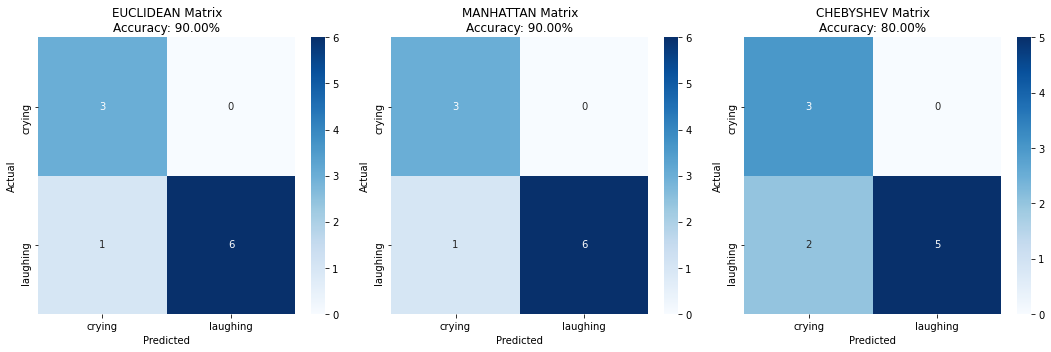

In [38]:
metrics = ['euclidean', 'manhattan', 'chebyshev']
results = {}

plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics, 1):
    # Training dan testing
    knn = KNeighborsClassifier(n_neighbors=3, metric=metric)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[metric] = acc
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=folders, yticklabels=folders)
    plt.title(f'{metric.upper()} Matrix\nAccuracy: {acc:.2%}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [39]:
print("\nClassification Report untuk", metric.upper())
print(classification_report(y_test, y_pred))


Classification Report untuk CHEBYSHEV
              precision    recall  f1-score   support

      crying       0.60      1.00      0.75         3
    laughing       1.00      0.71      0.83         7

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10

